# Interrupted Time Series (ITS) with scikit-learn models

This notebook shows an example of using interrupted time series, where we do not have untreated control units of a similar nature to the treated unit and we just have a single time series of observations and the predictor variables are simply time and month.

In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression

import causalpy as cp

In [2]:
%config InlineBackend.figure_format = 'retina'

## Load data

In [3]:
df = (
    cp.load_data("its")
    .assign(date=lambda x: pd.to_datetime(x["date"]))
    .set_index("date")
)

treatment_time = pd.to_datetime("2017-01-01")
df.head()

,month,year,t,y
date,,,,
2010-01-31,1,2010,0,25.058186
2010-02-28,2,2010,1,27.189812
2010-03-31,3,2010,2,26.487551
2010-04-30,4,2010,3,31.241716
2010-05-31,5,2010,4,40.753973


## Run the analysis

In [4]:
result = cp.InterruptedTimeSeries(
    df,
    treatment_time,
    formula="y ~ 1 + t + C(month)",
    model=LinearRegression(),
)

## Examine the results

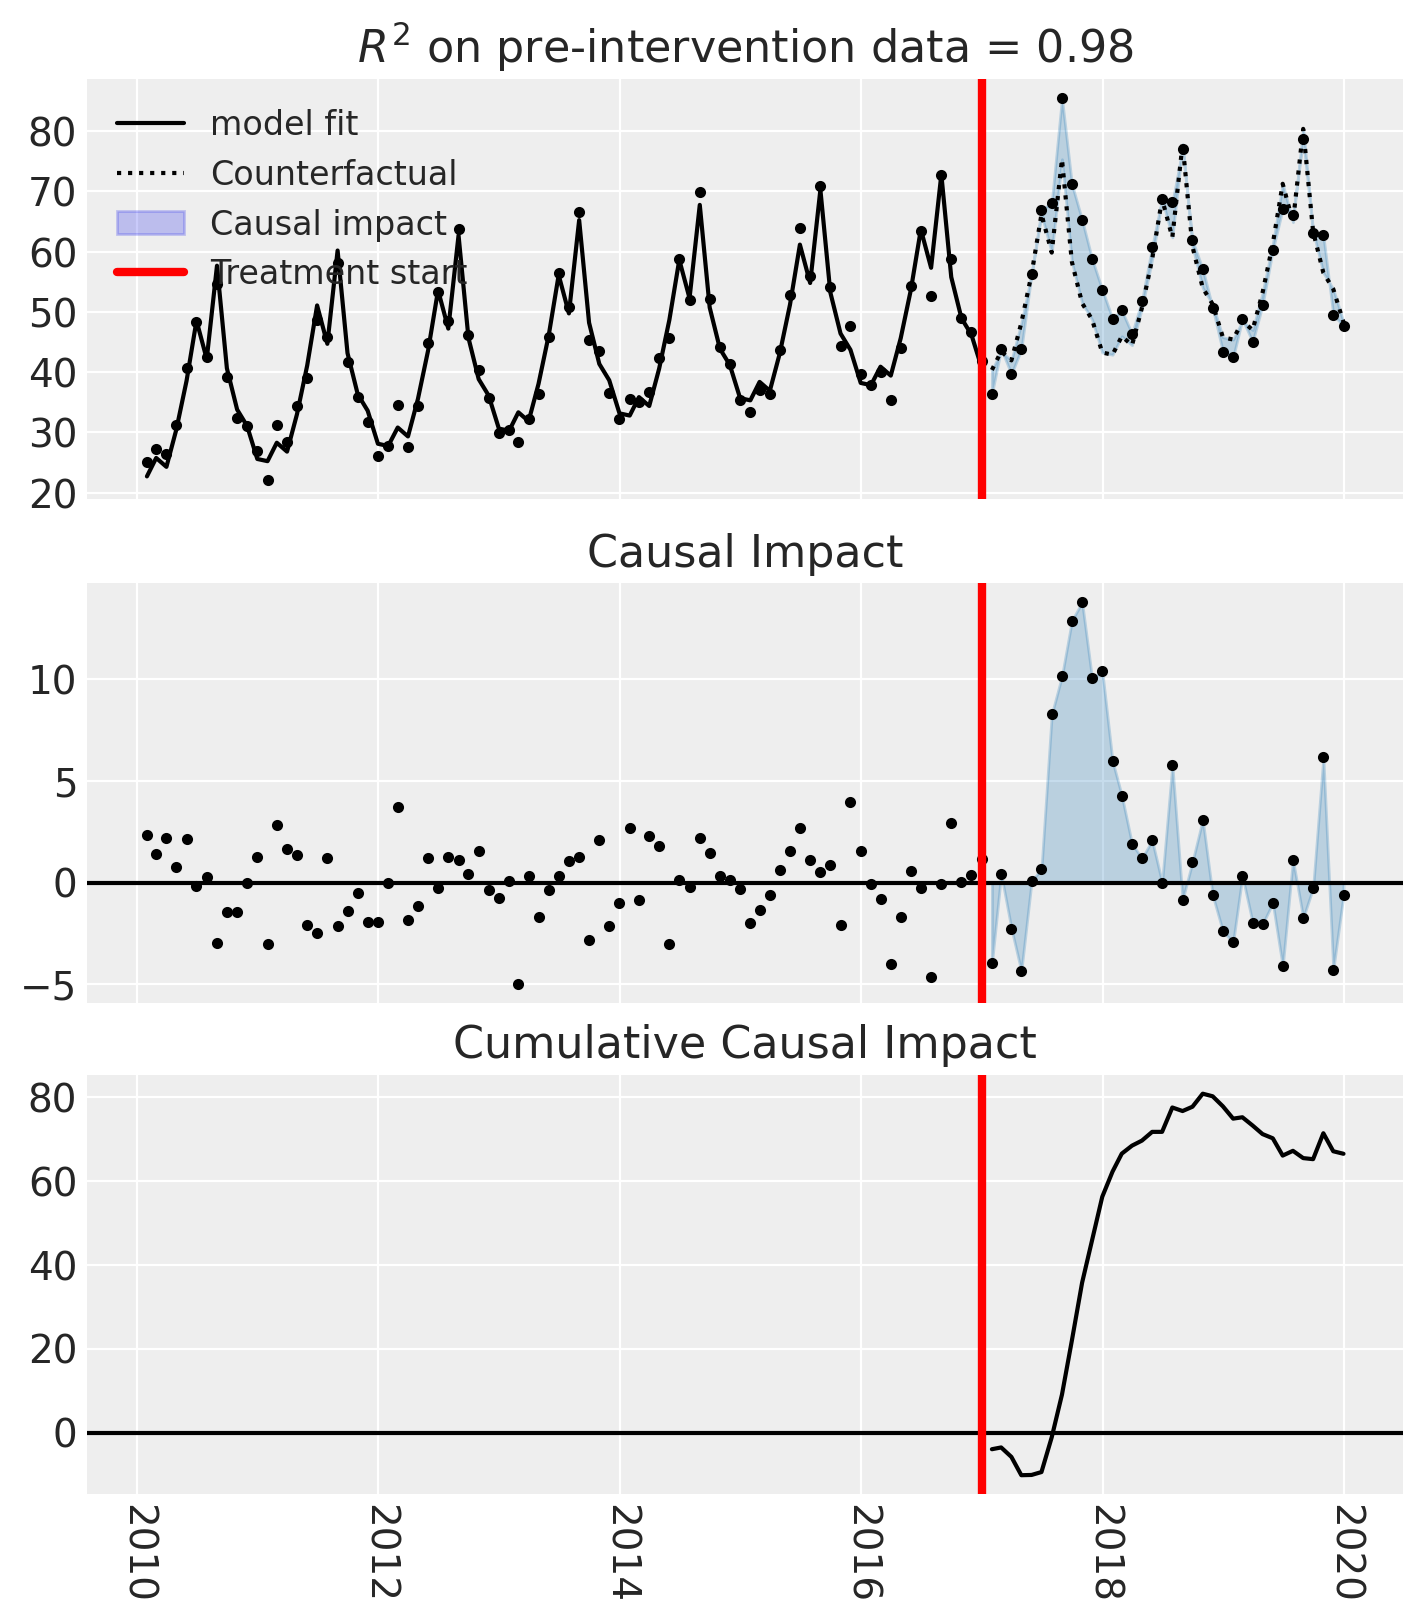

In [5]:
fig, ax = result.plot()

In [6]:
result.summary(round_to=3)

==================================Pre-Post Fit==================================
Formula: y ~ 1 + t + C(month)
Model coefficients:
  Intercept     	         0
  C(month)[T.2] 	      2.85
  C(month)[T.3] 	      1.16
  C(month)[T.4] 	      7.15
  C(month)[T.5] 	        15
  C(month)[T.6] 	      24.8
  C(month)[T.7] 	      18.2
  C(month)[T.8] 	      33.5
  C(month)[T.9] 	      16.2
  C(month)[T.10]	      9.19
  C(month)[T.11]	      6.28
  C(month)[T.12]	     0.578
  t             	      0.21


## Effect Summary Reporting

For decision-making, you often need a concise summary of the causal effect. The `effect_summary()` method provides a decision-ready report with key statistics.

:::{note}
**OLS vs PyMC Models**: When using OLS models (scikit-learn), the `effect_summary()` provides **confidence intervals** and **p-values** (frequentist inference), rather than the posterior distributions, HDI intervals, and tail probabilities provided by PyMC models (Bayesian inference). OLS tables include: mean, CI_lower, CI_upper, and p_value, but do not include median, tail probabilities (P(effect>0)), or ROPE probabilities.
:::


In [7]:
# Generate effect summary for the full post-period
stats = result.effect_summary()
stats.table

,mean,ci_lower,ci_upper,p_value,relative_mean,relative_ci_lower,relative_ci_upper
average,1.845561,0.161437,3.529686,0.032645,3.366709,0.150601,6.582817
cumulative,66.440209,5.811718,127.068701,0.032645,121.201506,5.421618,236.981394


In [8]:
# View the prose summary
print(stats.text)

During the post-period (2017-01-31 00:00:00 to 2019-12-31 00:00:00), the response variable had an average value of approx. 57.15. By contrast, in the absence of an intervention, we would have expected an average response of 55.30. The 95% confidence interval of this counterfactual prediction is [53.62, 56.99]. Subtracting this prediction from the observed response yields an estimate of the causal effect the intervention had on the response variable. This effect is 1.85 with a 95% confidence interval of [0.16, 3.53].

Summing up the individual data points during the post-period, the response variable had an overall value of 2057.42. By contrast, had the intervention not taken place, we would have expected a sum of 1990.98. The 95% confidence interval of this prediction is [1930.35, 2051.61].

The effect is statistically significant at the 0.05 level: the 95% confidence interval excludes zero, with a p-value of 0.033. Relative to the counterfactual, the effect represents a 3.37% change (